In [50]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import CelebA,ImageFolder
from PIL import Image
import torchvision.utils as vutils
from torchvision.transforms import transforms
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [51]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize the images
])

In [52]:
class CelebDataset(Dataset):
    def __init__(self,img_dir,transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir,self.img_names[index])
        image = Image.open(img_path).convert('RGB')
        if(self.transform):
            image = self.transform(image)
        return image
         

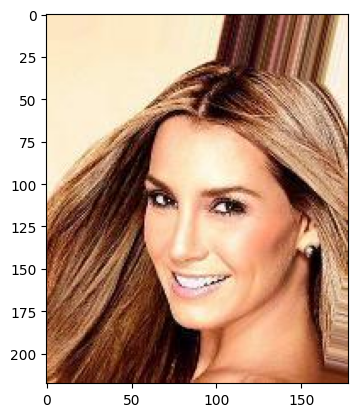

In [53]:
img = cv2.cvtColor(cv2.imread('./celeba/img_align_celeba/000001.jpg'),cv2.COLOR_BGR2RGB)
plt.imshow(img)

# prepare dataset

In [54]:
# celeb_dataset = CelebDataset(img_dir='img_align_celeba',transform=transform)

In [55]:
# batch_size = 32

In [56]:
# create a dataloader
# dataloader = DataLoader(celeb_dataset,batch_size=batch_size,shuffle=True)

In [57]:
# dataloader

In [58]:
# Number of workers for dataloader
workers = 2

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

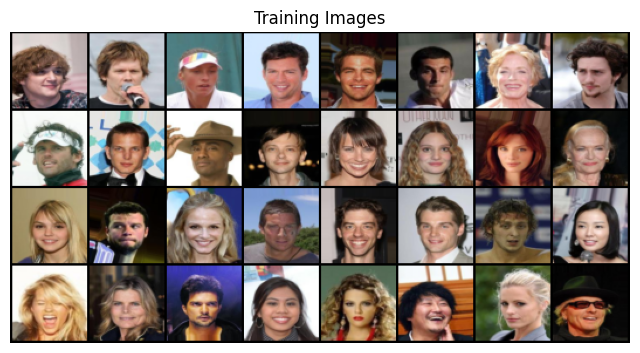

In [59]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = ImageFolder(root='./celeba',
                           transform=transforms.Compose([
                               transforms.Resize((64,64)),
                               transforms.CenterCrop((64,64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [60]:
import torch.nn as nn
random_noise = 100
class Generator(nn.Module):
    def __init__(self,random_noise = 100) :
        super(Generator,self).__init__()
        self.fc = nn.Sequential(
            # 100 -> 8*8*1024
            nn.Linear(random_noise, 8*8*1024),
            nn.BatchNorm1d(8*8*1024),
            nn.ReLU(True)
        )
        self.gen = nn.Sequential(
            # # 16*16*2048 -> 32*32*1024
            # nn.ConvTranspose2d(2048,1024,kernel_size=4,stride=2,padding=1),
            # nn.BatchNorm2d(1024),
            # nn.ReLU(True),

            # 8*8*1024 -> 16*16*512
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # 16*16*512 -> 32*32*256
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 32*32*256 -> 64*64*3
            nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 1024, 8, 8)  # Corrected reshape
        return self.gen(x)
    
######### GENERATING IMAGE OF SIZE 128x128 TOOK A LOT OF COMPUTATIONAL REASOURCES ##########
# class Generator(nn.Module):
#     def __init__(self,random_noise = 100) :
#         super(Generator,self).__init__()
#         self.fc = nn.Sequential(
#             # 100 -> 16*16*2048
#             nn.Linear(random_noise,16*16*2048),
#             nn.BatchNorm1d(16*16*2048),
#             nn.ReLU(True)
#         )
#         self.gen = nn.Sequential(
#             # 16*16*2048 -> 32*32*1024
#             nn.ConvTranspose2d(2048,1024,kernel_size=4,stride=2,padding=1),
#             nn.BatchNorm2d(1024),
#             nn.ReLU(True),

#             # 32*32*1024 -> 64*64*512
#             nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),

#             # 64*64*512 -> 128*128*3
#             nn.ConvTranspose2d(512,3,kernel_size=4,stride=2,padding=1),
#             nn.Tanh()
#         )

#     def forward(self,z):
#         x = self.fc(z)
#         # Reshape to (batch_size, 2048, 16, 16)
#         x = x.view(-1,2048,16,16)
#         return self.gen(x)

In [69]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input 64*64*3 image -> feature map 32*32*256
            nn.Conv2d(3, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            # 32*32*256 -> 16*16*512
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            # 16*16*512 -> 8*8*1024
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, True)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*8*8, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.disc(z)
        return self.fc(x)
    
############### TRAINING THE DISCRIMINATOR FOR IMAGES OF SIZE 128x128 TOOK A LOT OF TRAINING TIME IN THIS DEVICE (27 hours 50 min approx)
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator,self).__init__()
#         # input 128*128*3 image -> feature map 64*64*512
#         self.disc = nn.Sequential(
#             nn.Conv2d(3,512,kernel_size=4,stride=2,padding=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2,True),

#             nn.Conv2d(512,1024,4,2,1),
#             nn.LeakyReLU(0.2,True),

#             nn.Conv2d(1024,2048,4,2,1),
#             nn.LeakyReLU(0.2,True)
#         )

#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(2048*16*16,1),
#             nn.Sigmoid()
#         )
#     def forward(self,z):
#         x = self.disc(z)
#         return self.fc(x)    

In [70]:
gen = Generator()
disc = Discriminator()

In [71]:
epochs = 10
lr = 2e-4
b1=0.5
b2=0.999

In [72]:
adverserial_loss = nn.BCELoss()

In [73]:
from torch.optim import Adam

gen_opt = Adam(gen.parameters(),lr=lr,betas=(b1,b2))
disc_opt = Adam(disc.parameters(),lr=lr,betas=(b1,b2))


In [74]:
gen.to(device)
disc.to(device)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [75]:
import torch.nn.functional as F


In [77]:
from tqdm import tqdm

# Assuming you have your dataloader, models, and optimizers set up

num_epochs = 3  # Set this to your desired number of epochs
steps_per_epoch = len(dataloader)

for epoch in range(num_epochs):
    # Create a progress bar for each epoch
    progress_bar = tqdm(enumerate(dataloader), total=steps_per_epoch, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (real_imgs, _) in progress_bar:
        real_imgs = real_imgs.to(device)
        current_batch_size = real_imgs.size(0)
        
        # Train Discriminator
        disc_opt.zero_grad()
        
        z = torch.randn(current_batch_size, random_noise, device=device)
        fake_imgs = gen(z)
        
        disc_real = disc(real_imgs).view(-1)
        disc_fake = disc(fake_imgs.detach()).view(-1)
        
        disc_loss = (
            F.binary_cross_entropy_with_logits(disc_real, torch.ones_like(disc_real)) +
            F.binary_cross_entropy_with_logits(disc_fake, torch.zeros_like(disc_fake))
        )
        
        disc_loss.backward()
        disc_opt.step()
        
        # Train Generator
        gen_opt.zero_grad()
        
        gen_fake = disc(fake_imgs).view(-1)
        gen_loss = F.binary_cross_entropy_with_logits(gen_fake, torch.ones_like(gen_fake))
        
        gen_loss.backward()
        gen_opt.step()
        
        # Update progress bar
        progress_bar.set_postfix({
            'D Loss': f'{disc_loss.item():.4f}',
            'G Loss': f'{gen_loss.item():.4f}'
        })
    

Epoch 3/3: 100%|██████████| 6332/6332 [08:54<00:00, 11.84it/s, D Loss=1.0064, G Loss=0.6931]  


In [82]:
torch.save(gen.state_dict(),'./model weights/DCGen.pt')
torch.save(disc.state_dict(),'./model weights/DCDisc.pt')

In [83]:
torch.save(gen,'./model weights/DCGen.pth')
torch.save(disc,'./model weights/DCDisc.pth')